In this notebook, we compare the three models under a simple R&S setting.

We will use the functions defined in `rs_kg_w_s_tilde` for sampling decisions.

In [1]:
from time import time
from typing import List, Tuple

import torch
from botorch import fit_gpytorch_model, settings
from gpytorch import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from torch import Tensor
# from torch.multiprocessing import Pool, set_start_method
# try:
#      set_start_method('spawn')
# except RuntimeError:
#     pass
from multiprocessing import Pool

from contextual_rs.lce_gp import LCEGP
from contextual_rs.unknown_correlation_model import UnknownCorrelationModel
from contextual_rs.rs_kg_w_s_tilde import find_kg_maximizer

%matplotlib inline
import matplotlib.pyplot as plt


Let's compare the performance by optimizing via KG. The maximizer of the posterior
mean will be used as the predicted best arm.

Overwriting the random model with the MVN example from moment matching paper.

In [5]:
def model_constructor(model_type: str):
    def model_create(X, Y):
        if model_type == "LCEGP":
            model = LCEGP(
                X.view(-1, 1), Y.view(-1, 1), categorical_cols=[0], embs_dim_list=[2]
            )
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)
            return model
        else:
            model = UnknownCorrelationModel(X, Y, update_method=model_type)
            return model
    return model_create


labels = ["LCEGP", "moment-matching", "KL", "moment-KL"]

model_constructor_list = [
    model_constructor(m_type) for m_type in labels
]
start = None


def single_replication(
    rep: int,
    iterations: int,
    fit_frequency: int,
    sampling_post: MultivariateNormal,
    train_X: Tensor,
    train_Y: Tensor,
    num_alternatives: int,
) -> Tuple[int, List[Tensor]]:
    all_alternatives = torch.arange(num_alternatives, dtype=torch.float).view(-1, 1, 1)
    pred_bests = [torch.zeros(iterations) for _ in range(4)]
    X_list = [train_X.clone() for _ in range(4)]
    Y_list = [train_Y.clone() for _ in range(4)]
    old_lcegp = None
    for i in range(iterations):
        if i == 0:
            print(f"Starting replication {rep}, iteration {i}, time: {time()-start}")
        next_points = torch.zeros(4)
        for j in range(4):
            constructor = model_constructor_list[j]
            if fit_frequency > 1 and j == 0 and i % fit_frequency != 0:
                # in this case, we will not re-train LCEGP.
                # we will just condition on observations.
                model = old_lcegp.condition_on_observations(
                    X=X_list[j][-1].view(-1, 1),
                    Y=Y_list[j][-1].view(-1, 1),
                )
            else:
                model = constructor(X_list[j], Y_list[j])

            if j:
                pred_bests[j][i] = model.theta.argmax()
            else:
                # LCEGP
                pred_bests[j][i] = model.posterior(all_alternatives).mean.argmax()
                old_lcegp = model

            next_points[j] = find_kg_maximizer(model)

        full_eval = sampling_post.rsample().view(-1).detach()
        next_evals = full_eval[next_points.long()]

        for j in range(4):
            X_list[j] = torch.cat([X_list[j], next_points[j].view(-1)], dim=-1)
            Y_list[j] = torch.cat([Y_list[j], next_evals[j].view(-1)], dim=-1)
    return rep, pred_bests


def main_run(
    num_alternatives: int,
    rho: float,
    num_full_train: int,
    iterations: int,
    replications: int,
    fit_frequency = 1,  # set > 1 if we don't want to fit LCEMGP at each iteration.
    use_multiprocessing: bool = False,
):
    global start
    K = num_alternatives
    true_mean = torch.linspace(0, 1, K)
    true_cov = torch.zeros(K, K)
    for i in range(K):
        for j in range(K):
            true_cov[i, j] = torch.tensor(rho).pow(abs(i - j))
    sampling_post = MultivariateNormal(true_mean, true_cov)

    train_X = torch.arange(num_alternatives, dtype=torch.float).repeat(num_full_train)
    train_Y = sampling_post.rsample(torch.Size([num_full_train])).view(-1).detach()

    predicted_bests = [torch.zeros(replications, iterations) for _ in range(4)]
    start = time()

    arg_list = list()
    for rep in range(replications):
        arg_list.append([
            rep, iterations, fit_frequency, sampling_post,
            train_X, train_Y, num_alternatives
        ])

    if use_multiprocessing:
        pool = Pool(processes=min(10, replications))
        results = pool.starmap(single_replication, arg_list)
        pool.close()
        pool.join()
        for rep, pred_best in results:
            for i in range(4):
                predicted_bests[i][rep] = pred_best[i]
    else:
        for rep in range(replications):
            _, pred_best = single_replication(*arg_list[rep])
            for i in range(4):
                predicted_bests[i][rep] = pred_best[i]

    plot_values = [
        sampling_post.mean[tmp.long()].detach().mean(dim=0) for tmp in predicted_bests
    ]
    fig = plt.figure(figsize=(12, 8))
    fig.patch.set_facecolor('xkcd:mint green')

    for i in range(4):
        plt.plot(plot_values[i], label=labels[i])
    plt.axhline(sampling_post.mean.max(), label="true_best")
    plt.grid()
    plt.legend()
    plt.show()

Starting replication 0, iteration 0, time: 0.00011181831359863281
Starting replication 1, iteration 0, time: 83.59786677360535
Starting replication 2, iteration 0, time: 162.0380380153656
Starting replication 3, iteration 0, time: 235.345449924469
Starting replication 4, iteration 0, time: 318.242308139801


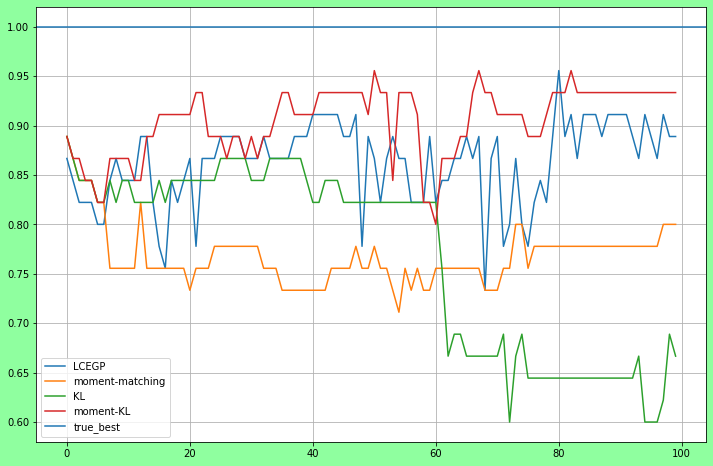

In [3]:
main_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=10,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 9.179115295410156e-05
Starting replication 1, iteration 0, time: 149.27734088897705
Starting replication 2, iteration 0, time: 313.04772996902466
Starting replication 3, iteration 0, time: 460.86994671821594
Starting replication 4, iteration 0, time: 627.0096032619476


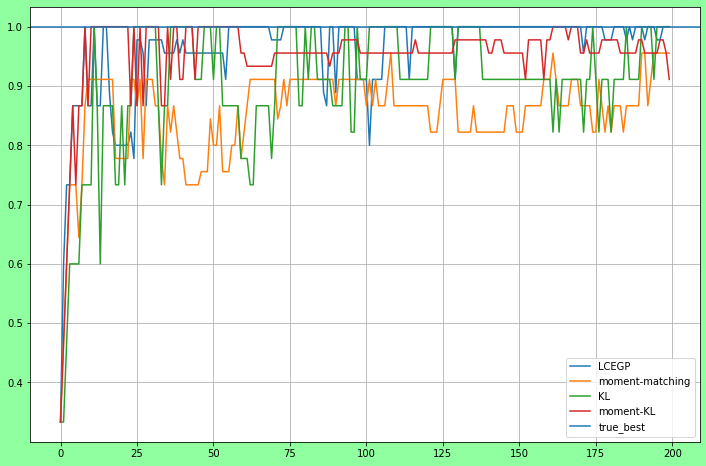

In [4]:
main_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=5,
    iterations=200,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.2901763916015625e-05
Starting replication 1, iteration 0, time: 205.22545385360718
Starting replication 2, iteration 0, time: 434.44714426994324
Starting replication 3, iteration 0, time: 646.8673560619354
Starting replication 4, iteration 0, time: 852.0443227291107


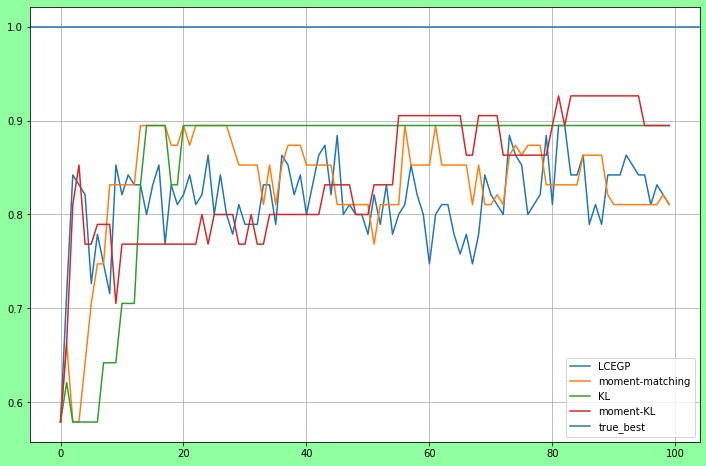

In [5]:
main_run(
    num_alternatives=20,
    rho=0.5,
    num_full_train=10,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.528594970703125e-05
Starting replication 1, iteration 0, time: 159.8596453666687
Starting replication 2, iteration 0, time: 324.5791325569153
Starting replication 3, iteration 0, time: 473.1721901893616
Starting replication 4, iteration 0, time: 610.4612159729004


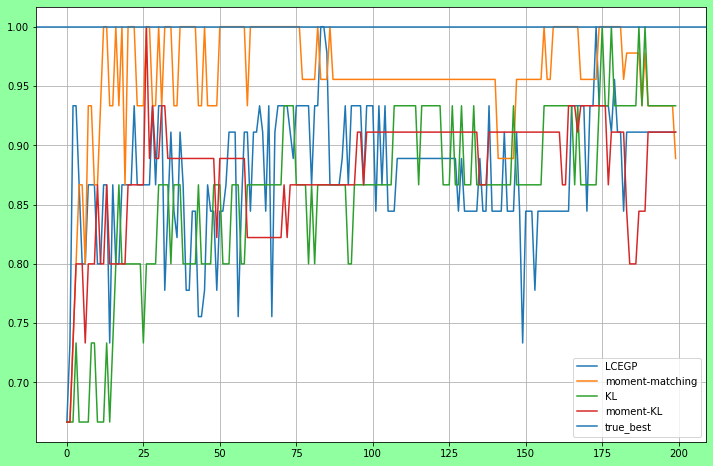

In [6]:
main_run(
    num_alternatives=10,
    rho=0.1,
    num_full_train=5,
    iterations=200,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.5762786865234375e-05
Starting replication 1, iteration 0, time: 208.81535172462463
Starting replication 2, iteration 0, time: 467.62635111808777
Starting replication 3, iteration 0, time: 689.5888895988464
Starting replication 4, iteration 0, time: 915.0718419551849


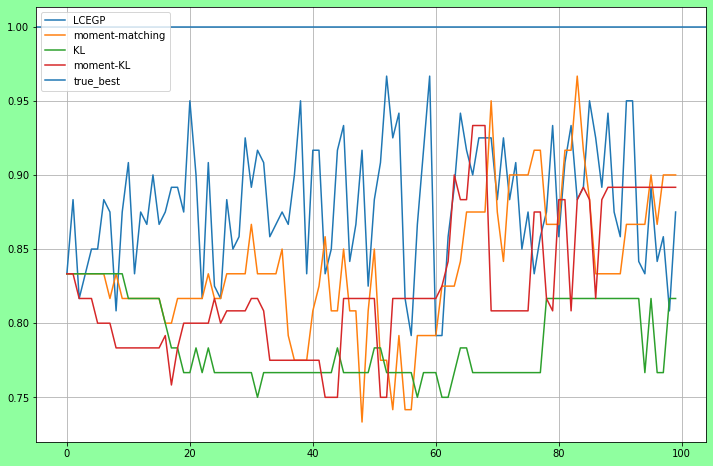

In [7]:
main_run(
    num_alternatives=25,
    rho=0.9,
    num_full_train=10,
    iterations=100,
    replications=5,
)


Starting replication 0, iteration 0, time: 3.838539123535156e-05
Starting replication 1, iteration 0, time: 90.4430627822876
Starting replication 2, iteration 0, time: 184.37591767311096
Starting replication 3, iteration 0, time: 272.87507128715515
Starting replication 4, iteration 0, time: 364.1374430656433
Starting replication 5, iteration 0, time: 449.0491156578064
Starting replication 6, iteration 0, time: 530.1464011669159
Starting replication 7, iteration 0, time: 612.5466494560242
Starting replication 8, iteration 0, time: 703.3119072914124
Starting replication 9, iteration 0, time: 790.2642321586609


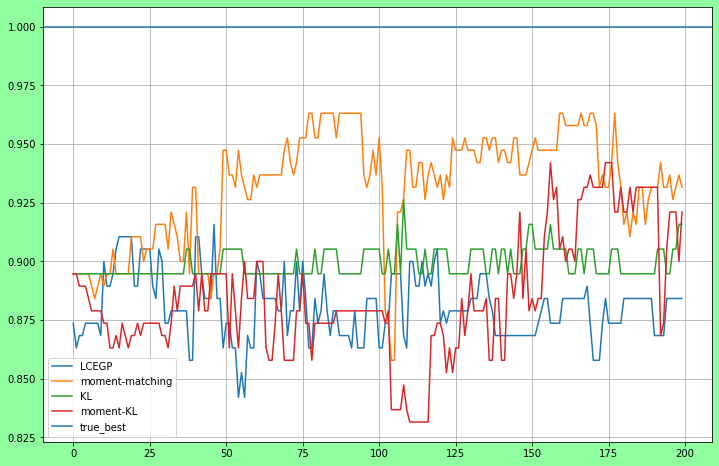

In [14]:
main_run(
    num_alternatives=20,
    rho=0.7,
    num_full_train=5,
    iterations=200,
    replications=10,
    fit_frequency=10,
)

Starting replication 0, iteration 0, time: 0.00021529197692871094
Starting replication 1, iteration 0, time: 214.49041152000427
Starting replication 2, iteration 0, time: 449.2667398452759
Starting replication 3, iteration 0, time: 674.6186990737915
Starting replication 4, iteration 0, time: 884.5232071876526


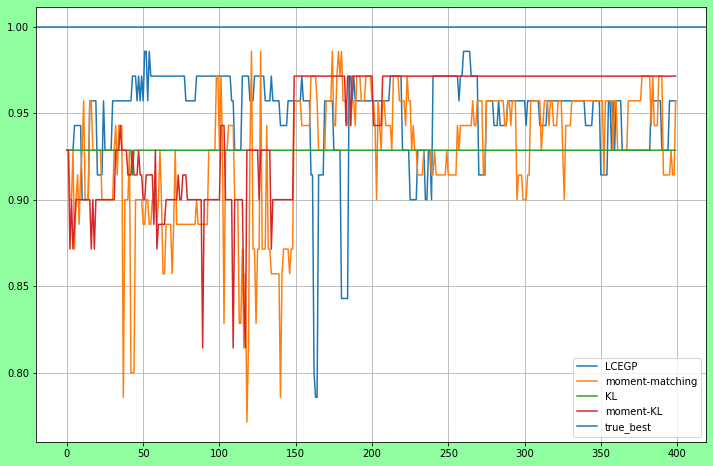

In [6]:
main_run(
    num_alternatives=15,
    rho=0.7,
    num_full_train=3,
    iterations=400,
    replications=5,
    fit_frequency=5,
)

Starting replication 0, iteration 0, time: 0.00015592575073242188
Starting replication 1, iteration 0, time: 538.6805045604706
Starting replication 2, iteration 0, time: 1103.50089097023
Starting replication 3, iteration 0, time: 1624.4361019134521
Starting replication 4, iteration 0, time: 2183.7579243183136


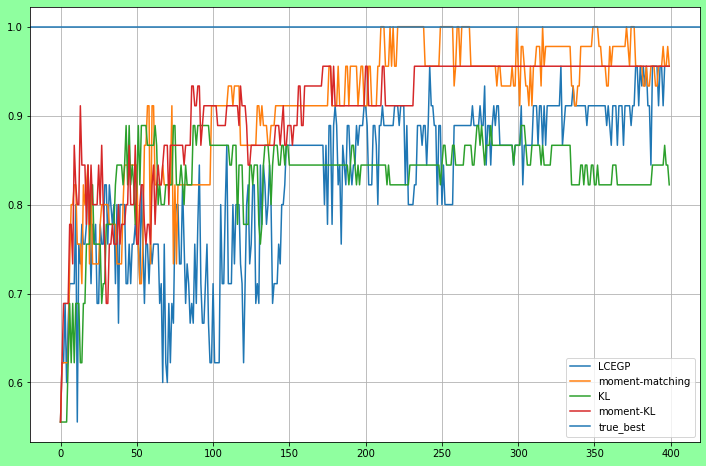

In [7]:
main_run(
    num_alternatives=10,
    rho=0.2,
    num_full_train=3,
    iterations=400,
    replications=5 ,
)


Starting replication 0, iteration 0, time: 7.009506225585938e-05
Starting replication 1, iteration 0, time: 327.01311898231506
Starting replication 2, iteration 0, time: 649.8760900497437
Starting replication 3, iteration 0, time: 987.3398542404175
Starting replication 4, iteration 0, time: 1286.7407913208008


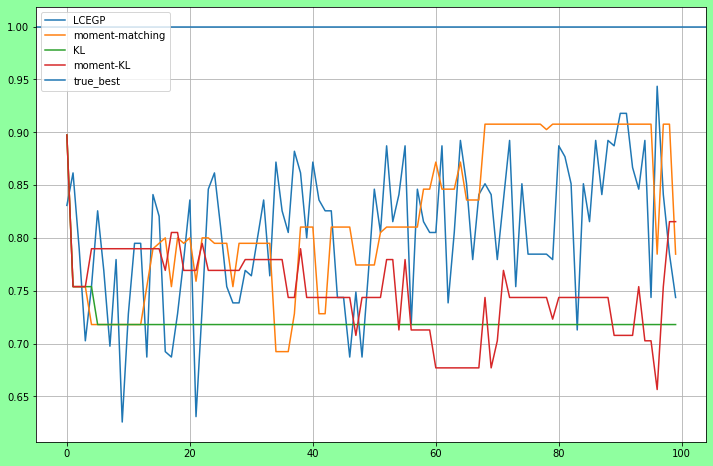

In [8]:
main_run(
    num_alternatives=40,
    rho=0.1,
    num_full_train=5,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 9.5367431640625e-05
Starting replication 1, iteration 0, time: 148.06510424613953
Starting replication 2, iteration 0, time: 296.3563289642334
Starting replication 3, iteration 0, time: 469.4232964515686
Starting replication 4, iteration 0, time: 633.2942419052124
Starting replication 5, iteration 0, time: 797.8233599662781
Starting replication 6, iteration 0, time: 905.8016831874847
Starting replication 7, iteration 0, time: 1005.4661462306976
Starting replication 8, iteration 0, time: 1160.0930392742157
Starting replication 9, iteration 0, time: 1317.442774772644


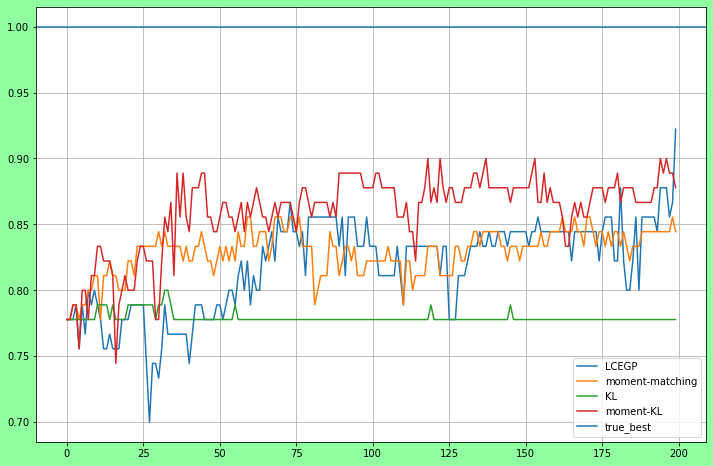

In [9]:
main_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=3,
    iterations=200,
    replications=10,
)
